# Дипломный проект. Практическая часть

## прогноз оттокa клиентов

**Задача**

У оператора связи задача научиться прогнозировать отток клиентов. Если пользователь хочет уйти с определенной вероятностью, оператор предложит ему промокоды и спец-условия. 
Предоставлены персональные данные о клиентах, так же информация о тарифах и договорах.

У оператора есть два типа услуг: 
1 - стационарная телефонная связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DS** от англ.*digital subscriber lin*, «цифровая абонентская линия») или оптоволоконный кабель *Fiber opti)*.

Предоставленные данные:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

`customerID` содержит код клиента.
Данные на 1 февраля 2020.

*Загрузим необходимые библиотеки*

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')  
import os
import os.path
import re

import datetime

import phik

import sklearn
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import NearestNeighbors 
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import TransformerMixin
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.ensemble import RandomForestClassifier

from catboost import CatBoostClassifier

import lightgbm as lgb
import random

from tensorflow import keras
import tensorflow as tf

*Загрузим данные из внешних таблиц*

In [9]:
    contracts = pd.read_csv('contract.csv')
    internet = pd.read_csv('internet.csv')
    personal = pd.read_csv('personal.csv')
    phones = pd.read_csv('phone.csv')

**предобработка таблиц перед слиянием**

**Контракты**

In [12]:
contracts.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


In [13]:
def describer(data):
    temp = data.describe()
    temp.loc['nan'] = [data[el].isna().sum() for el in data.describe().columns]
    temp.loc['duplicates'] = [data.duplicated().sum() for el in data.describe().columns]
    display(temp)
    
    for el in data.columns:
        print(el)
        print(data[el].value_counts(dropna=False))
        print()
        print(f'{el} NAN: {data[el].isna().sum()}')
        print(f'{el} unique: {data[el].nunique()}')
        print()

In [14]:
describer(contracts)

,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000
nan,0.000000
duplicates,0.000000


customerID
customerID
7590-VHVEG    1
3791-LGQCY    1
6008-NAIXK    1
5956-YHHRX    1
5365-LLFYV    1
             ..
9796-MVYXX    1
2637-FKFSY    1
1552-AAGRX    1
4304-TSPVK    1
3186-AJIEK    1
Name: count, Length: 7043, dtype: int64

customerID NAN: 0
customerID unique: 7043

BeginDate
BeginDate
2014-02-01    366
2019-10-01    237
2019-11-01    237
2019-09-01    237
2020-01-01    233
             ... 
2020-02-01     11
2014-01-01      7
2013-10-01      3
2013-12-01      3
2013-11-01      2
Name: count, Length: 77, dtype: int64

BeginDate NAN: 0
BeginDate unique: 77

EndDate
EndDate
No            5942
2020-01-01      39
2019-12-01      38
2018-11-01      35
2019-09-01      32
              ... 
2014-09-01       2
2014-12-01       2
2014-06-01       1
2014-10-01       1
2014-11-01       1
Name: count, Length: 67, dtype: int64

EndDate NAN: 0
EndDate unique: 67

Type
Type
Month-to-month    3875
Two year          1695
One year          1473
Name: count, dtype: int64

Type NAN: 0
Type 

In [15]:
contracts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


Выводы по данным contracts:

1. Каждый контракт соответствует одному клиенту - повторяющихся customer_id нет.

2. Пропусков также нет, однако есть пустые значения по __total_charges_жно испмвить; также нужно привести столбец к нужному числовому формату..

4. Нужно привести даты к нужному формату и выделить столбец _target_ - после этого все _no_ в __enddate__ можно заменить на дату сбора данных, чтобы отдельно выделить столбец с продолжительностью использованиобнаружено

Пропуски по TotalCharges и формат данных:

In [18]:
contracts.loc[contracts.TotalCharges==' ']

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


Пропуски есть только по клиентам, к-е подключились в месяц сбора статистики - эти 11 строк мы удалим, ввиду того что их мало:

In [20]:
contracts = contracts.drop(contracts.loc[contracts.TotalCharges==' '].index).reset_index(drop=True)
contracts.TotalCharges = contracts.TotalCharges.astype(np.float32)

Формат дат

In [22]:
contracts['BeginDate'] = pd.to_datetime(contracts.BeginDate)
contracts.loc[contracts.EndDate == 'No','target'] = 0
contracts.loc[contracts.EndDate != 'No','target'] = 1
contracts['EndDate_remake'] = contracts.EndDate.replace('No','2020-02-01')

contracts.EndDate_remake = pd.to_datetime(contracts.EndDate_remake)

In [23]:
contracts['activity'] = (contracts.EndDate_remake - contracts.BeginDate).dt.days

In [24]:
contracts.sample(5)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target,EndDate_remake,activity
3423,7872-BAAZR,2015-09-01,No,One year,No,Bank transfer (automatic),19.55,1036.150024,0.0,2020-02-01,1614
1871,3946-JEWRQ,2016-03-01,2019-02-01,One year,Yes,Credit card (automatic),95.20,3398.639893,1.0,2019-02-01,1067
335,4322-RCYMT,2014-03-01,2018-03-01,One year,Yes,Bank transfer (automatic),75.80,3638.399902,1.0,2018-03-01,1461
1180,4660-IRIBM,2018-08-01,No,Month-to-month,Yes,Mailed check,87.90,1582.199951,0.0,2020-02-01,549
2064,6356-ELRKD,2019-11-01,No,Month-to-month,Yes,Electronic check,95.60,306.880005,0.0,2020-02-01,92


**Интернет**


Тут есть дополнительные услуги, подключенные пользователяем интернета

In [27]:
internet

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...
5512,6840-RESVB,DSL,Yes,No,Yes,Yes,Yes,Yes
5513,2234-XADUH,Fiber optic,No,Yes,Yes,No,Yes,Yes
5514,4801-JZAZL,DSL,Yes,No,No,No,No,No
5515,8361-LTMKD,Fiber optic,No,No,No,No,No,No


In [28]:
describer(internet)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785
nan,0,0,0,0,0,0,0,0
duplicates,0,0,0,0,0,0,0,0


customerID
customerID
7590-VHVEG    1
5181-OABFK    1
9356-AXGMP    1
5176-OLSKT    1
7508-DQAKK    1
             ..
1104-FEJAM    1
2972-YDYUW    1
4238-JSSWH    1
0869-PAPRP    1
3186-AJIEK    1
Name: count, Length: 5517, dtype: int64

customerID NAN: 0
customerID unique: 5517

InternetService
InternetService
Fiber optic    3096
DSL            2421
Name: count, dtype: int64

InternetService NAN: 0
InternetService unique: 2

OnlineSecurity
OnlineSecurity
No     3498
Yes    2019
Name: count, dtype: int64

OnlineSecurity NAN: 0
OnlineSecurity unique: 2

OnlineBackup
OnlineBackup
No     3088
Yes    2429
Name: count, dtype: int64

OnlineBackup NAN: 0
OnlineBackup unique: 2

DeviceProtection
DeviceProtection
No     3095
Yes    2422
Name: count, dtype: int64

DeviceProtection NAN: 0
DeviceProtection unique: 2

TechSupport
TechSupport
No     3473
Yes    2044
Name: count, dtype: int64

TechSupport NAN: 0
TechSupport unique: 2

StreamingTV
StreamingTV
No     2810
Yes    2707
Name: count, dtyp

Выводы по таблице интернет:
Дубликатов и пропусков также не видим

**Персонал**

In [31]:
personal

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes
7039,2234-XADUH,Female,0,Yes,Yes
7040,4801-JZAZL,Female,0,Yes,Yes
7041,8361-LTMKD,Male,1,Yes,No


In [32]:
describer(personal)

,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000
nan,0.000000
duplicates,0.000000


customerID
customerID
7590-VHVEG    1
3791-LGQCY    1
6008-NAIXK    1
5956-YHHRX    1
5365-LLFYV    1
             ..
9796-MVYXX    1
2637-FKFSY    1
1552-AAGRX    1
4304-TSPVK    1
3186-AJIEK    1
Name: count, Length: 7043, dtype: int64

customerID NAN: 0
customerID unique: 7043

gender
gender
Male      3555
Female    3488
Name: count, dtype: int64

gender NAN: 0
gender unique: 2

SeniorCitizen
SeniorCitizen
0    5901
1    1142
Name: count, dtype: int64

SeniorCitizen NAN: 0
SeniorCitizen unique: 2

Partner
Partner
No     3641
Yes    3402
Name: count, dtype: int64

Partner NAN: 0
Partner unique: 2

Dependents
Dependents
No     4933
Yes    2110
Name: count, dtype: int64

Dependents NAN: 0
Dependents unique: 2



In [33]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


Дубликатов и пропусков также не видим

**Phones**

In [36]:
phones.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [37]:
describer(phones)

,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390
nan,0,0
duplicates,0,0


customerID
customerID
5575-GNVDE    1
0980-FEXWF    1
8082-GHXOP    1
3393-FMZPV    1
8701-DGLVH    1
             ..
8197-BFWVU    1
9154-QDGTH    1
8499-BRXTD    1
8552-OBVRU    1
3186-AJIEK    1
Name: count, Length: 6361, dtype: int64

customerID NAN: 0
customerID unique: 6361

MultipleLines
MultipleLines
No     3390
Yes    2971
Name: count, dtype: int64

MultipleLines NAN: 0
MultipleLines unique: 2



Нет пропусков и дубликатов.

На данный момент план работы очень простой:
1. Объединить все таблицы в одну.
2. Решить, чем заменять пропуски в каждой конкретной ситуации.
3. Посмотреть на распределения непрерывных фичей, возможно - удалить выбросы.
4. Выделить таргет (факт расторжения договора) в отдельный столбец.
5. Посмотреть на матрицу корреляции, выбрать коллинеарные фичи, решить как и в каком порядке мы будем их выбрасывать, т к коллинеарные фичи мешают процессам машинного обучения.

### EDA

Объединим таблицы

In [41]:
df = contracts.merge(internet, on='customerID', how='left')

In [42]:
df = df.merge(personal, on='customerID', how='left')
df = df.merge(phones, on='customerID', how='left')

In [43]:
df.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', column).lower() for column in df.columns]

In [44]:
df.head()

,customer_i_d,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,target,end_date_remake,...,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.040001,0.0,2020-02-01,...,Yes,No,No,No,No,Female,0,Yes,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.840088,0.0,2020-02-01,...,No,Yes,No,No,No,Male,0,No,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.169998,0.0,2020-02-01,...,Yes,No,No,No,No,Male,0,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.599976,0.0,2020-02-01,...,No,Yes,Yes,No,No,Male,0,No,No,NaN
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.500000,0.0,2020-02-01,...,No,No,No,No,No,Female,0,No,No,No


Удалим столбец с АйДи клиентов (т к все уникальны) и заменим все _Yes и No_ на нули и единицы:

In [46]:
repl = {'Yes':1,'No':0}
df = df.replace(repl)
df = df.drop(columns='customer_i_d')

In [47]:
df.head()

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,target,end_date_remake,activity,...,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines
0,2020-01-01,0,Month-to-month,1,Electronic check,29.85,31.040001,0.0,2020-02-01,31,...,1.0,0.0,0.0,0.0,0.0,Female,0,1,0,NaN
1,2017-04-01,0,One year,0,Mailed check,56.95,2071.840088,0.0,2020-02-01,1036,...,0.0,1.0,0.0,0.0,0.0,Male,0,0,0,0.0
2,2019-10-01,0,Month-to-month,1,Mailed check,53.85,226.169998,0.0,2020-02-01,123,...,1.0,0.0,0.0,0.0,0.0,Male,0,0,0,0.0
3,2016-05-01,0,One year,0,Bank transfer (automatic),42.30,1960.599976,0.0,2020-02-01,1371,...,0.0,1.0,1.0,0.0,0.0,Male,0,0,0,NaN
4,2019-09-01,0,Month-to-month,1,Electronic check,70.70,353.500000,0.0,2020-02-01,153,...,0.0,0.0,0.0,0.0,0.0,Female,0,0,0,0.0


In [48]:
describer(df)

,begin_date,paperless_billing,monthly_charges,total_charges,target,end_date_remake,activity,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,senior_citizen,partner,dependents,multiple_lines
count,7032,7032.000000,7032.000000,7032.000000,7032.000000,7032,7032.000000,5512.000000,5512.000000,5512.000000,5512.000000,5512.000000,5512.000000,7032.000000,7032.000000,7032.000000,6352.000000
mean,2017-04-28 23:14:44.641638400,0.592719,64.798208,2118.621826,0.156570,2019-10-15 22:19:02.662116096,899.961320,0.365566,0.439949,0.438679,0.370102,0.490385,0.495464,0.162400,0.482509,0.298493,0.467097
min,2013-10-01 00:00:00,0.000000,18.250000,19.049999,0.000000,2014-06-01 00:00:00,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2015-06-01 00:00:00,0.000000,35.587500,439.745010,0.000000,2020-02-01 00:00:00,276.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2017-09-01 00:00:00,1.000000,70.350000,1345.274963,0.000000,2020-02-01 00:00:00,761.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2019-04-01 00:00:00,1.000000,89.862500,3239.317566,0.000000,2020-02-01 00:00:00,1461.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000
max,2020-01-01 00:00:00,1.000000,118.750000,9221.379883,1.000000,2020-02-01 00:00:00,2314.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
std,NaN,0.491363,30.085974,2112.734619,0.363421,NaN,682.738777,0.481632,0.496426,0.496271,0.482875,0.499953,0.500025,0.368844,0.499729,0.457629,0.498955
nan,0,0.000000,0.000000,0.000000,0.000000,0,0.000000,1520.000000,1520.000000,1520.000000,1520.000000,1520.000000,1520.000000,0.000000,0.000000,0.000000,680.000000
duplicates,4,4.000000,4.000000,4.000000,4.000000,4,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000


begin_date
begin_date
2014-02-01    366
2019-10-01    237
2019-11-01    237
2019-09-01    237
2020-01-01    233
             ... 
2016-11-01     50
2014-01-01      7
2013-10-01      3
2013-12-01      3
2013-11-01      2
Name: count, Length: 76, dtype: int64

begin_date NAN: 0
begin_date unique: 76

end_date
end_date
0             5931
2020-01-01      39
2019-12-01      38
2018-11-01      35
2019-09-01      32
              ... 
2014-09-01       2
2014-12-01       2
2014-06-01       1
2014-10-01       1
2014-11-01       1
Name: count, Length: 67, dtype: int64

end_date NAN: 0
end_date unique: 67

type
type
Month-to-month    3875
Two year          1685
One year          1472
Name: count, dtype: int64

type NAN: 0
type unique: 3

paperless_billing
paperless_billing
1    4168
0    2864
Name: count, dtype: int64

paperless_billing NAN: 0
paperless_billing unique: 2

payment_method
payment_method
Electronic check             2365
Mailed check                 1604
Bank transfer (automatic)   

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         7032 non-null   datetime64[ns]
 1   end_date           7032 non-null   object        
 2   type               7032 non-null   object        
 3   paperless_billing  7032 non-null   int64         
 4   payment_method     7032 non-null   object        
 5   monthly_charges    7032 non-null   float64       
 6   total_charges      7032 non-null   float32       
 7   target             7032 non-null   float64       
 8   end_date_remake    7032 non-null   datetime64[ns]
 9   activity           7032 non-null   int64         
 10  internet_service   5512 non-null   object        
 11  online_security    5512 non-null   float64       
 12  online_backup      5512 non-null   float64       
 13  device_protection  5512 non-null   float64       
 14  tech_sup

In [50]:
df.isna().sum()

begin_date              0
end_date                0
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
target                  0
end_date_remake         0
activity                0
internet_service     1520
online_security      1520
online_backup        1520
device_protection    1520
tech_support         1520
streaming_t_v        1520
streaming_movies     1520
gender                  0
senior_citizen          0
partner                 0
dependents              0
multiple_lines        680
dtype: int64

Видно что есть пропуски по:
- доп. услугам при подключении интернета - заменим их просто на нули
- пропуски по подключению нескольких телефонных линий одному клиенту - также заполним нулями
- используем фичу multiple_lines для определения, подключен ли телефон вообще
- пропуски по типу подключения интернета заменим на _no_internet_

In [52]:
df['phone'] = ~df.multiple_lines.isna() * 1

In [53]:
df.internet_service = df.internet_service.fillna('no_internet')

df = df.fillna(0)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         7032 non-null   datetime64[ns]
 1   end_date           7032 non-null   object        
 2   type               7032 non-null   object        
 3   paperless_billing  7032 non-null   int64         
 4   payment_method     7032 non-null   object        
 5   monthly_charges    7032 non-null   float64       
 6   total_charges      7032 non-null   float32       
 7   target             7032 non-null   float64       
 8   end_date_remake    7032 non-null   datetime64[ns]
 9   activity           7032 non-null   int64         
 10  internet_service   7032 non-null   object        
 11  online_security    7032 non-null   float64       
 12  online_backup      7032 non-null   float64       
 13  device_protection  7032 non-null   float64       
 14  tech_sup

столбцы с датами пока оставим, хотя в дальнейшем они не пригодятся.
Такж ое остались 4 параметра с ти м _objct_: __type, payment_method, internet_service и genr__
1. _ype__ мы закодируем по продолжительности оплаты - 1, 12 и 24 соответстве2. 
2. __Internseet_rvice__ закодируем в порядке возрастания технологии: 0 - интернета нет, 1 - dsl, 2 - fiber3. tic
3. Остальные 2 признака закодируечерез _ne-hot__ коу.
__В любом случае, далее при обучении модели мы будем создавать новый энкодер, чтобы не допустить еутечки данных__

In [55]:
work_df = df.copy(deep=True)
work_df = work_df.drop(columns=['begin_date','end_date','end_date_remake'])
work_df.type.unique()

array(['Month-to-month', 'One year', 'Two year'], dtype=object)

In [56]:
type_repl = {'Month-to-month':1,'One year':12, 'Two year':24}
work_df = work_df.replace(type_repl)
work_df.internet_service.unique()

array(['DSL', 'Fiber optic', 'no_internet'], dtype=object)

In [57]:
net_repl = {'DSL':1,'no_internet':0,'Fiber optic':2}
work_df = work_df.replace(net_repl)
work_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               7032 non-null   int64  
 1   paperless_billing  7032 non-null   int64  
 2   payment_method     7032 non-null   object 
 3   monthly_charges    7032 non-null   float64
 4   total_charges      7032 non-null   float32
 5   target             7032 non-null   float64
 6   activity           7032 non-null   int64  
 7   internet_service   7032 non-null   int64  
 8   online_security    7032 non-null   float64
 9   online_backup      7032 non-null   float64
 10  device_protection  7032 non-null   float64
 11  tech_support       7032 non-null   float64
 12  streaming_t_v      7032 non-null   float64
 13  streaming_movies   7032 non-null   float64
 14  gender             7032 non-null   object 
 15  senior_citizen     7032 non-null   int64  
 16  partner            7032 

In [58]:
def encoding(data, encoder, data_type='object', drop_first=True):
    
    if data_type == 'object':
        
        enc_cols = data.select_dtypes(include=data_type).columns.tolist()
        encoder.fit(data[enc_cols])
        
        if drop_first==True:
            col = []
            for el in encoder.categories_:
                col += el[1:].tolist()
        
        elif drop_first==False:
            col = []
            for el in encoder.categories_:
                col += el.tolist()
            
        
        transformed = encoder.transform(data[enc_cols])
        data[col] = transformed
        data = data.drop(columns=enc_cols)
    
    if data_type == 'number':
        
        enc_cols = data.select_dtypes(include=data_type).columns.tolist()
        data[enc_cols] = encoder.fit_transform(data[enc_cols])

    
    return data, encoder
    
    



temp_enc = OneHotEncoder(drop='first', sparse=False)

work_df, temp_ohe = encoding(work_df, temp_enc)

work_df

,type,paperless_billing,monthly_charges,total_charges,target,activity,internet_service,online_security,online_backup,device_protection,...,streaming_movies,senior_citizen,partner,dependents,multiple_lines,phone,Credit card (automatic),Electronic check,Mailed check,Male
0,1,1,29.85,31.040001,0.0,31,1,0.0,1.0,0.0,...,0.0,0,1,0,0.0,0,0.0,1.0,0.0,0.0
1,12,0,56.95,2071.840088,0.0,1036,1,1.0,0.0,1.0,...,0.0,0,0,0,0.0,1,0.0,0.0,1.0,1.0
2,1,1,53.85,226.169998,0.0,123,1,1.0,1.0,0.0,...,0.0,0,0,0,0.0,1,0.0,0.0,1.0,1.0
3,12,0,42.30,1960.599976,0.0,1371,1,1.0,0.0,1.0,...,0.0,0,0,0,0.0,0,0.0,0.0,0.0,1.0
4,1,1,70.70,353.500000,0.0,153,2,0.0,0.0,0.0,...,0.0,0,0,0,0.0,1,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,12,1,84.80,2035.199951,0.0,730,1,1.0,0.0,1.0,...,1.0,0,1,1,1.0,1,0.0,0.0,1.0,1.0
7028,12,1,103.20,7430.399902,0.0,2191,2,0.0,1.0,1.0,...,1.0,0,1,1,1.0,1,1.0,0.0,0.0,0.0
7029,1,1,29.60,325.600006,0.0,337,1,1.0,0.0,0.0,...,0.0,0,1,1,0.0,0,0.0,1.0,0.0,0.0
7030,1,1,74.40,520.799988,0.0,215,2,0.0,0.0,0.0,...,0.0,1,1,0,1.0,1,0.0,0.0,1.0,1.0


In [59]:
work_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   type                     7032 non-null   int64  
 1   paperless_billing        7032 non-null   int64  
 2   monthly_charges          7032 non-null   float64
 3   total_charges            7032 non-null   float32
 4   target                   7032 non-null   float64
 5   activity                 7032 non-null   int64  
 6   internet_service         7032 non-null   int64  
 7   online_security          7032 non-null   float64
 8   online_backup            7032 non-null   float64
 9   device_protection        7032 non-null   float64
 10  tech_support             7032 non-null   float64
 11  streaming_t_v            7032 non-null   float64
 12  streaming_movies         7032 non-null   float64
 13  senior_citizen           7032 non-null   int64  
 14  partner                 

Разберем матрицу корреляции - выберем коллинеарные фичи, и попробуем с ними поработать

Посмотрим на корреляции. Будем использовать коэффициент корреляции $\phi_k$

In [62]:
def heatmap(data,row=None, corr=True):
    sns.set(font_scale=1.5)
    if corr:
        if row:
            plt.figure(figsize=(20,len(data.corr()[row].to_frame().T) * 2))
            sns.heatmap(data.phik_matrix()[row].to_frame().T, annot=True, annot_kws={'fontsize':18}, cmap='YlGnBu')
        else:
            plt.figure(figsize=(25,20))
            sns.heatmap(data.phik_matrix(), annot=True, annot_kws={'fontsize':18}, cmap='YlGnBu')
    else:
        plt.figure(figsize=(20,15))
        sns.heatmap(data, annot=True, annot_kws={'fontsize':17}, cmap='YlGnBu')

interval columns not set, guessing: ['type', 'paperless_billing', 'monthly_charges', 'total_charges', 'target', 'activity', 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_t_v', 'streaming_movies', 'senior_citizen', 'partner', 'dependents', 'multiple_lines', 'phone', 'Credit card (automatic)', 'Electronic check', 'Mailed check', 'Male']


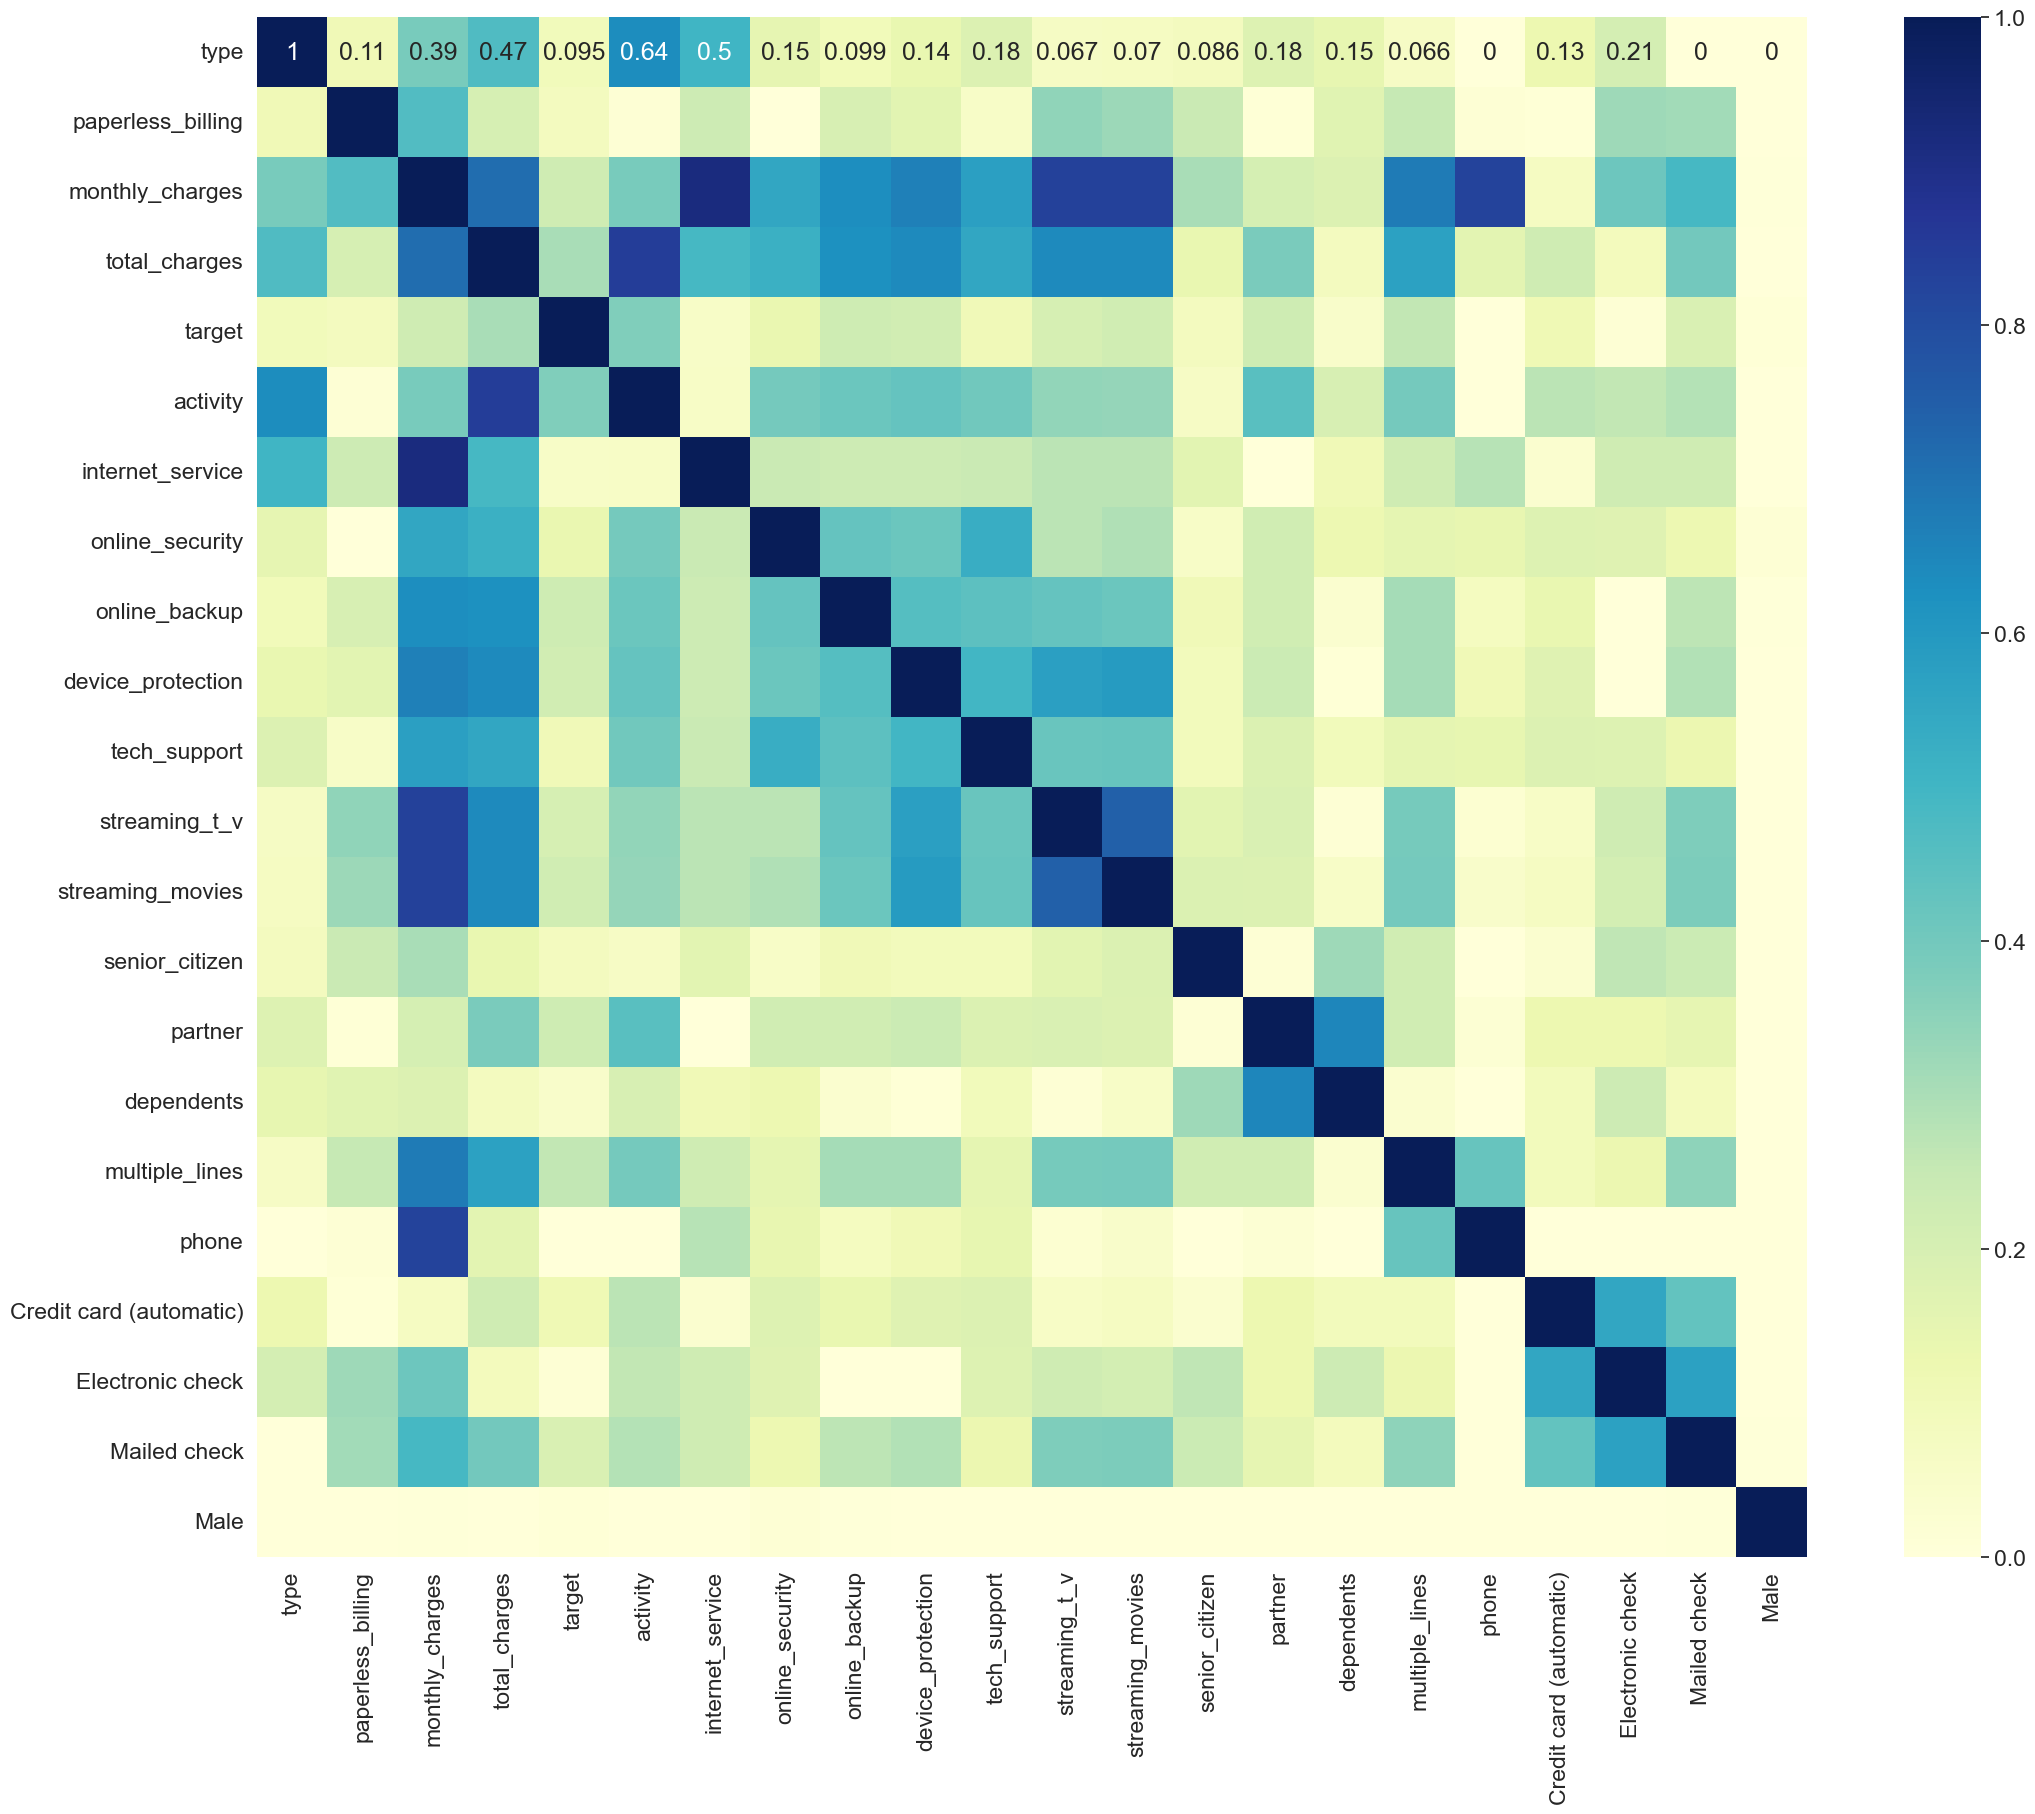

In [63]:
heatmap(work_df)

Здесь нас интересуют все фичи, кроме:
- Male - не коррелируют ни с одним другим признаком;
- multiple_lines и phone - очень слабая корреляция с таргетом;
- online_backup, device_protection, multiple_lines, streaming_tv и streaming_movies - сильно коррелируют с ежемесячной оплатой и при этом низкая корреляция с таргетом; попробуем сложить их вместе и посмотрим на результат

In [65]:
work_df = work_df.drop(columns=['Male','multiple_lines','phone'])
df = df.drop(columns=['gender','phone','multiple_lines'])

Mы видим несколько коллинеарных признаков (сюда включаем те, что имеют коэффициент больше 0.8):
-_total_charge_ коррелирует с_monthly_charges и activit_ -удаляемя;
- стриминг ТВ и фильмов коррелирует с ежемесячной оплатой - при этом никакого вклада в таргти не да,ты их убер.м; __internet_serve__ __monthly_charали практически коллинеарны - с точки зрения корреляции важн __monthly_chars__, её остави __internet_serve__ - уберём- __parer_и __dependts__ достаточно сильно коррелируют друг с дрльно; попробуем переделать эту фичв __faly__ - единый признак и посмоовую корреляцию

Попробуем также добавить фичу по тратам мотрим, может она больше коррелирует с таргетом, чем ежемесячные траты

Итак, фронт работ:
- уберём стриминги, пересчитаем фичу по доп услугам;
- объединим __partner__ и __dependents__ в одну фичу;
- уберём __total_charges__ и __interneily_charge__

In [67]:
work_df = work_df.drop(columns=['streaming_t_v',
                                'streaming_movies','internet_service', 'total_charges'])

work_df.add_services = work_df[['online_backup','device_protection',
                                   'online_security','tech_support']].sum(axis=1)
work_df['add_services2'] = work_df.online_backup * work_df.device_protection * \
                            work_df.online_security * work_df.tech_support

Посмотрим как параметр партнера влияет на наш таргет

In [69]:
pd.DataFrame(work_df[['partner','target']].value_counts(normalize=True)).sort_values(by='partner')

proportion
partner target            
0       0.0       0.463168
        1.0       0.054323
1       0.0       0.380262
        1.0       0.102247

Попробуем усилить влияние двух логически связанных фич 'dependents' и 'partner', с помощью логистической регрессии

In [71]:
fam_model = LogisticRegression(max_iter=10000)
fam_model.fit(work_df[['dependents','partner']],work_df['target'])
roc_auc_score(work_df['target'],fam_model.predict_proba(work_df[['dependents','partner']])[:,1])

0.6111046027193439

In [72]:
fam_model.coef_

array([[-0.2227119 ,  0.91572861]])

In [73]:
work_df['family'] = work_df.dependents * fam_model.coef_[0][0] + work_df.partner * fam_model.coef_[0][1] + fam_model.intercept_

Вот как теперь выглядит наш датасет

In [75]:
work_df

,type,paperless_billing,monthly_charges,target,activity,online_security,online_backup,device_protection,tech_support,senior_citizen,partner,dependents,Credit card (automatic),Electronic check,Mailed check,add_services2,family
0,1,1,29.85,0.0,31,0.0,1.0,0.0,0.0,0,1,0,0.0,1.0,0.0,0.0,-1.204448
1,12,0,56.95,0.0,1036,1.0,0.0,1.0,0.0,0,0,0,0.0,0.0,1.0,0.0,-2.120177
2,1,1,53.85,0.0,123,1.0,1.0,0.0,0.0,0,0,0,0.0,0.0,1.0,0.0,-2.120177
3,12,0,42.30,0.0,1371,1.0,0.0,1.0,1.0,0,0,0,0.0,0.0,0.0,0.0,-2.120177
4,1,1,70.70,0.0,153,0.0,0.0,0.0,0.0,0,0,0,0.0,1.0,0.0,0.0,-2.120177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,12,1,84.80,0.0,730,1.0,0.0,1.0,1.0,0,1,1,0.0,0.0,1.0,0.0,-1.427160
7028,12,1,103.20,0.0,2191,0.0,1.0,1.0,0.0,0,1,1,1.0,0.0,0.0,0.0,-1.427160
7029,1,1,29.60,0.0,337,1.0,0.0,0.0,0.0,0,1,1,0.0,1.0,0.0,0.0,-1.427160
7030,1,1,74.40,0.0,215,0.0,0.0,0.0,0.0,1,1,0,0.0,0.0,1.0,0.0,-1.204448


Построим тепловую карту для наглядной оценки корреляций фич друг с другом и с таргетом

interval columns not set, guessing: ['type', 'paperless_billing', 'monthly_charges', 'target', 'activity', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'senior_citizen', 'partner', 'dependents', 'Credit card (automatic)', 'Electronic check', 'Mailed check', 'add_services2', 'family']


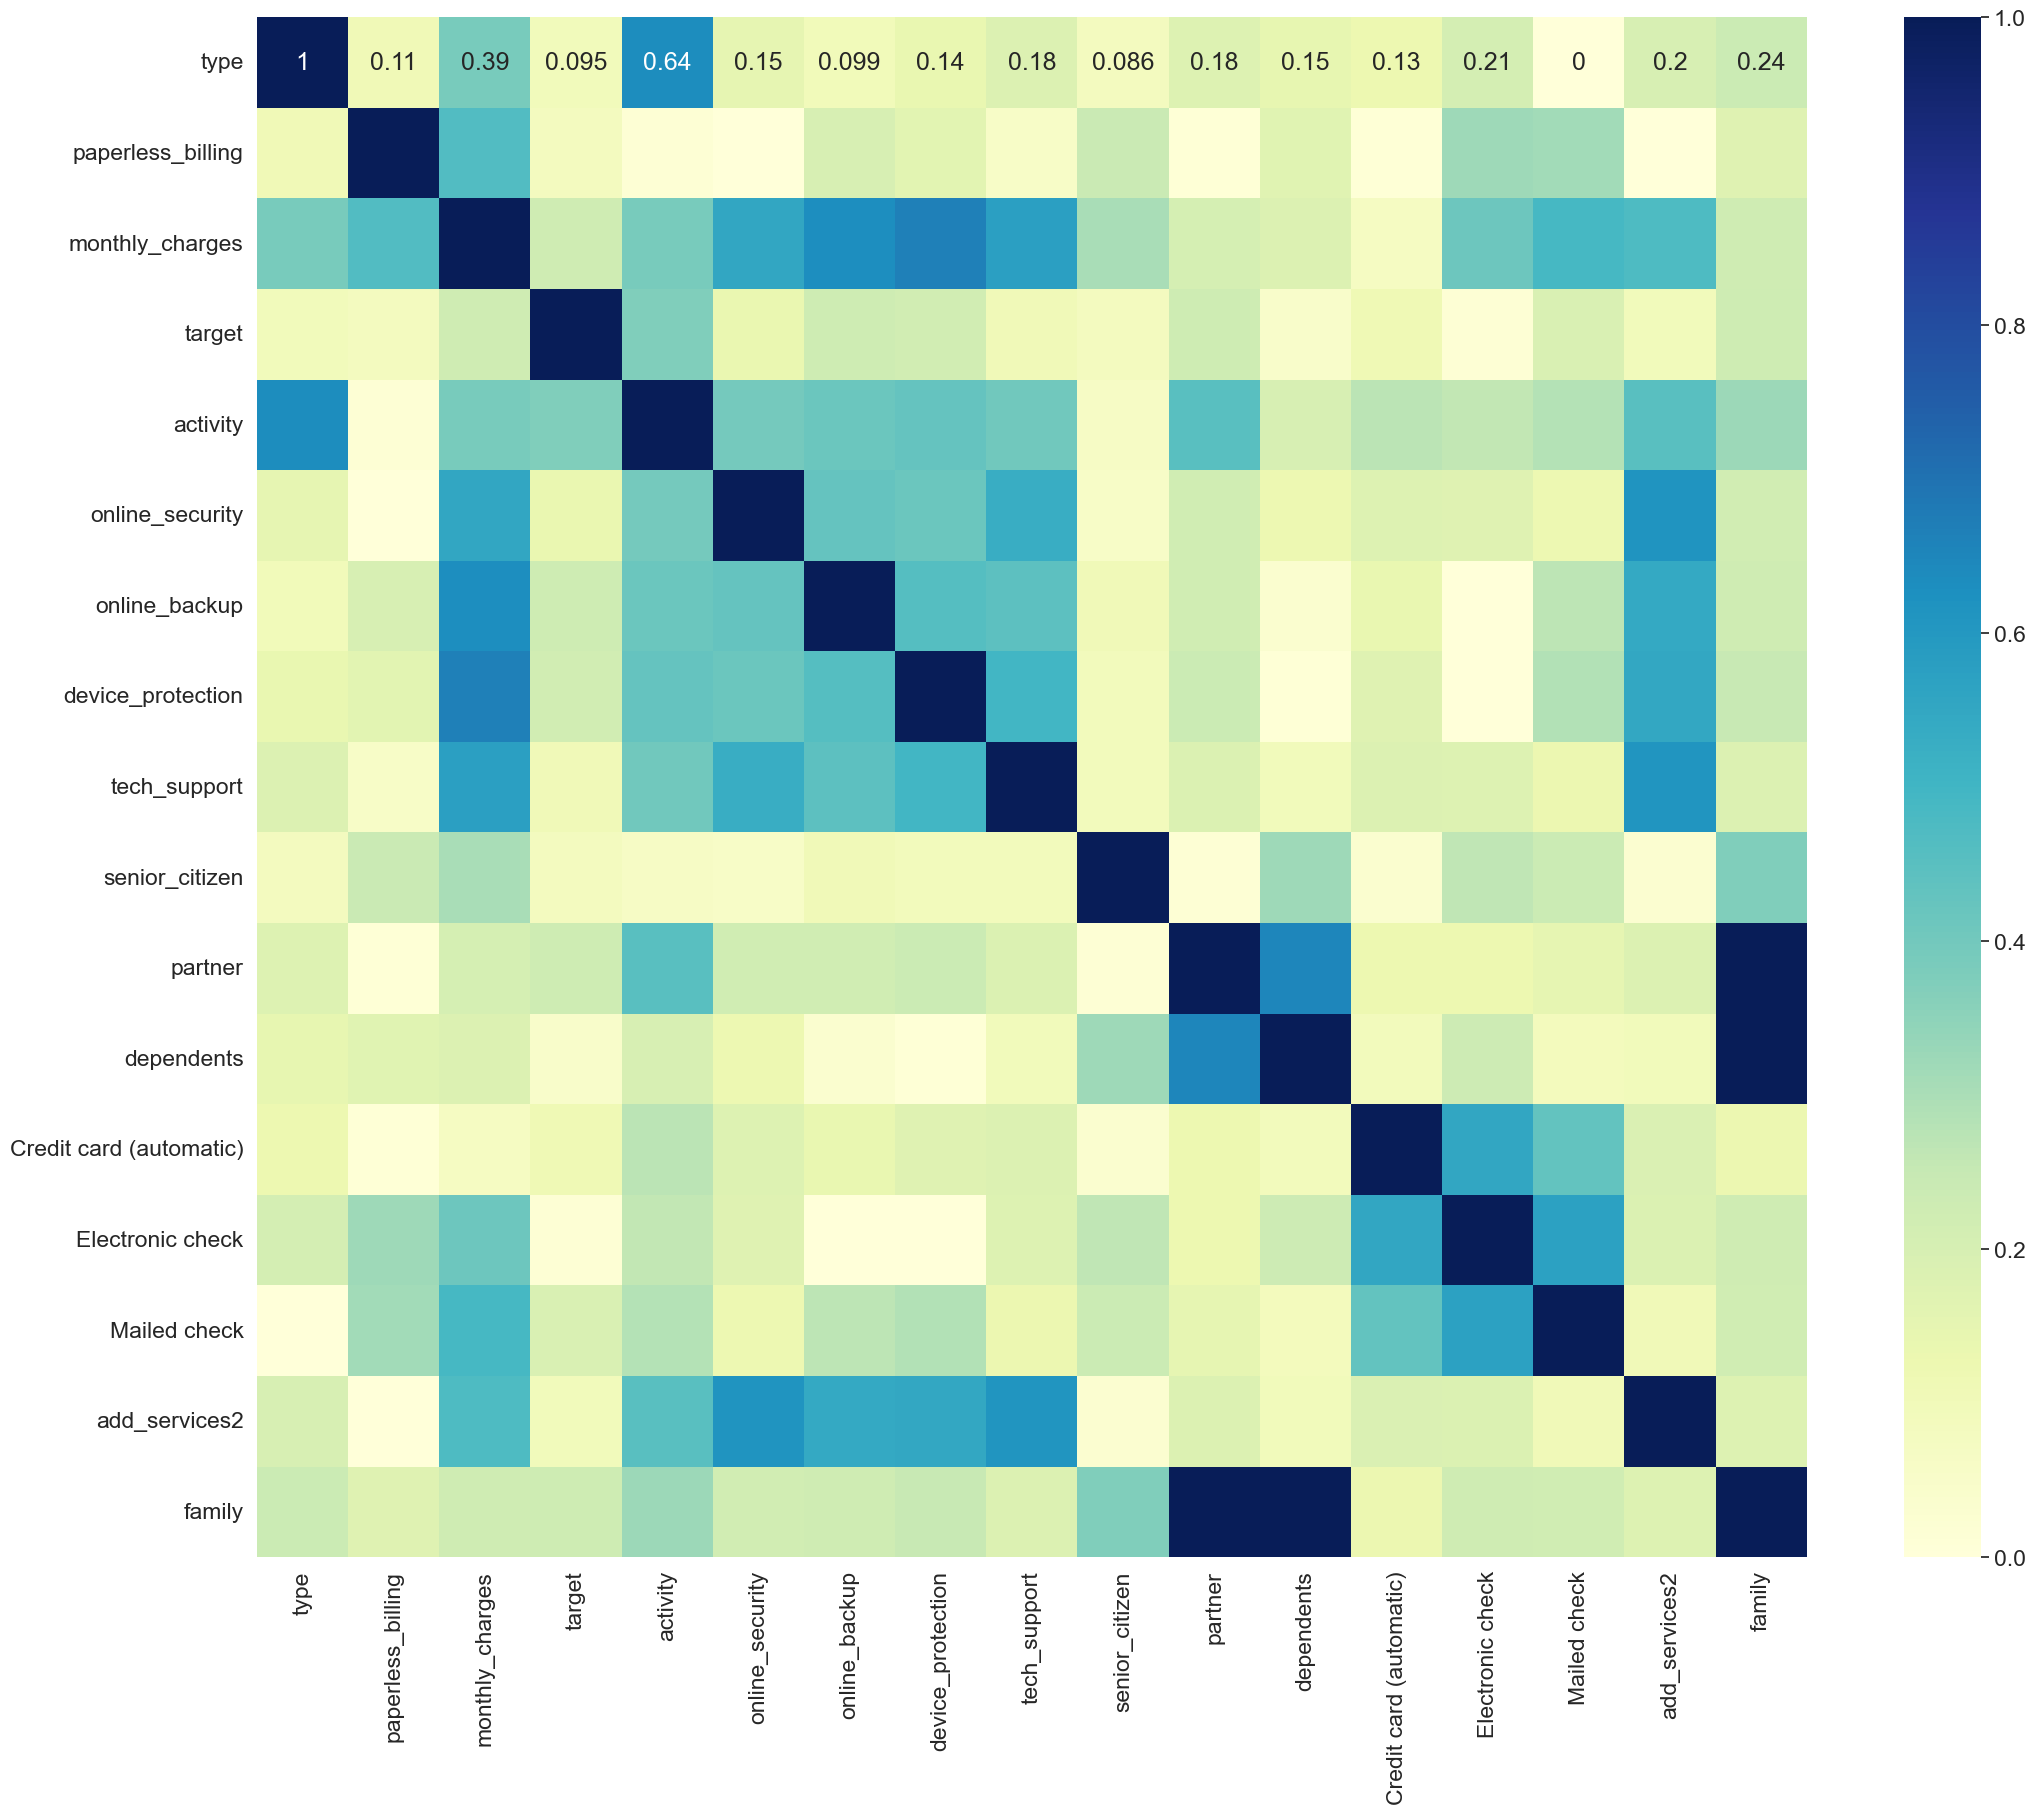

In [77]:
heatmap(work_df)

Усилим влияние смежных фич умножением друг на друга

In [79]:
work_df['security_plus_support'] = work_df.tech_support * work_df.online_security
work_df['backup_plus_protection'] = work_df.online_backup * work_df.device_protection

work_df = work_df.drop(columns=['online_backup', 'device_protection', 'tech_support', 'online_security', 'partner', 'dependents'])

work_df

,type,paperless_billing,monthly_charges,target,activity,senior_citizen,Credit card (automatic),Electronic check,Mailed check,add_services2,family,security_plus_support,backup_plus_protection
0,1,1,29.85,0.0,31,0,0.0,1.0,0.0,0.0,-1.204448,0.0,0.0
1,12,0,56.95,0.0,1036,0,0.0,0.0,1.0,0.0,-2.120177,0.0,0.0
2,1,1,53.85,0.0,123,0,0.0,0.0,1.0,0.0,-2.120177,0.0,0.0
3,12,0,42.30,0.0,1371,0,0.0,0.0,0.0,0.0,-2.120177,1.0,0.0
4,1,1,70.70,0.0,153,0,0.0,1.0,0.0,0.0,-2.120177,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,12,1,84.80,0.0,730,0,0.0,0.0,1.0,0.0,-1.427160,1.0,0.0
7028,12,1,103.20,0.0,2191,0,1.0,0.0,0.0,0.0,-1.427160,0.0,1.0
7029,1,1,29.60,0.0,337,0,0.0,1.0,0.0,0.0,-1.427160,0.0,0.0
7030,1,1,74.40,0.0,215,1,0.0,0.0,1.0,0.0,-1.204448,0.0,0.0


interval columns not set, guessing: ['type', 'paperless_billing', 'monthly_charges', 'target', 'activity', 'senior_citizen', 'Credit card (automatic)', 'Electronic check', 'Mailed check', 'add_services2', 'family', 'security_plus_support', 'backup_plus_protection']


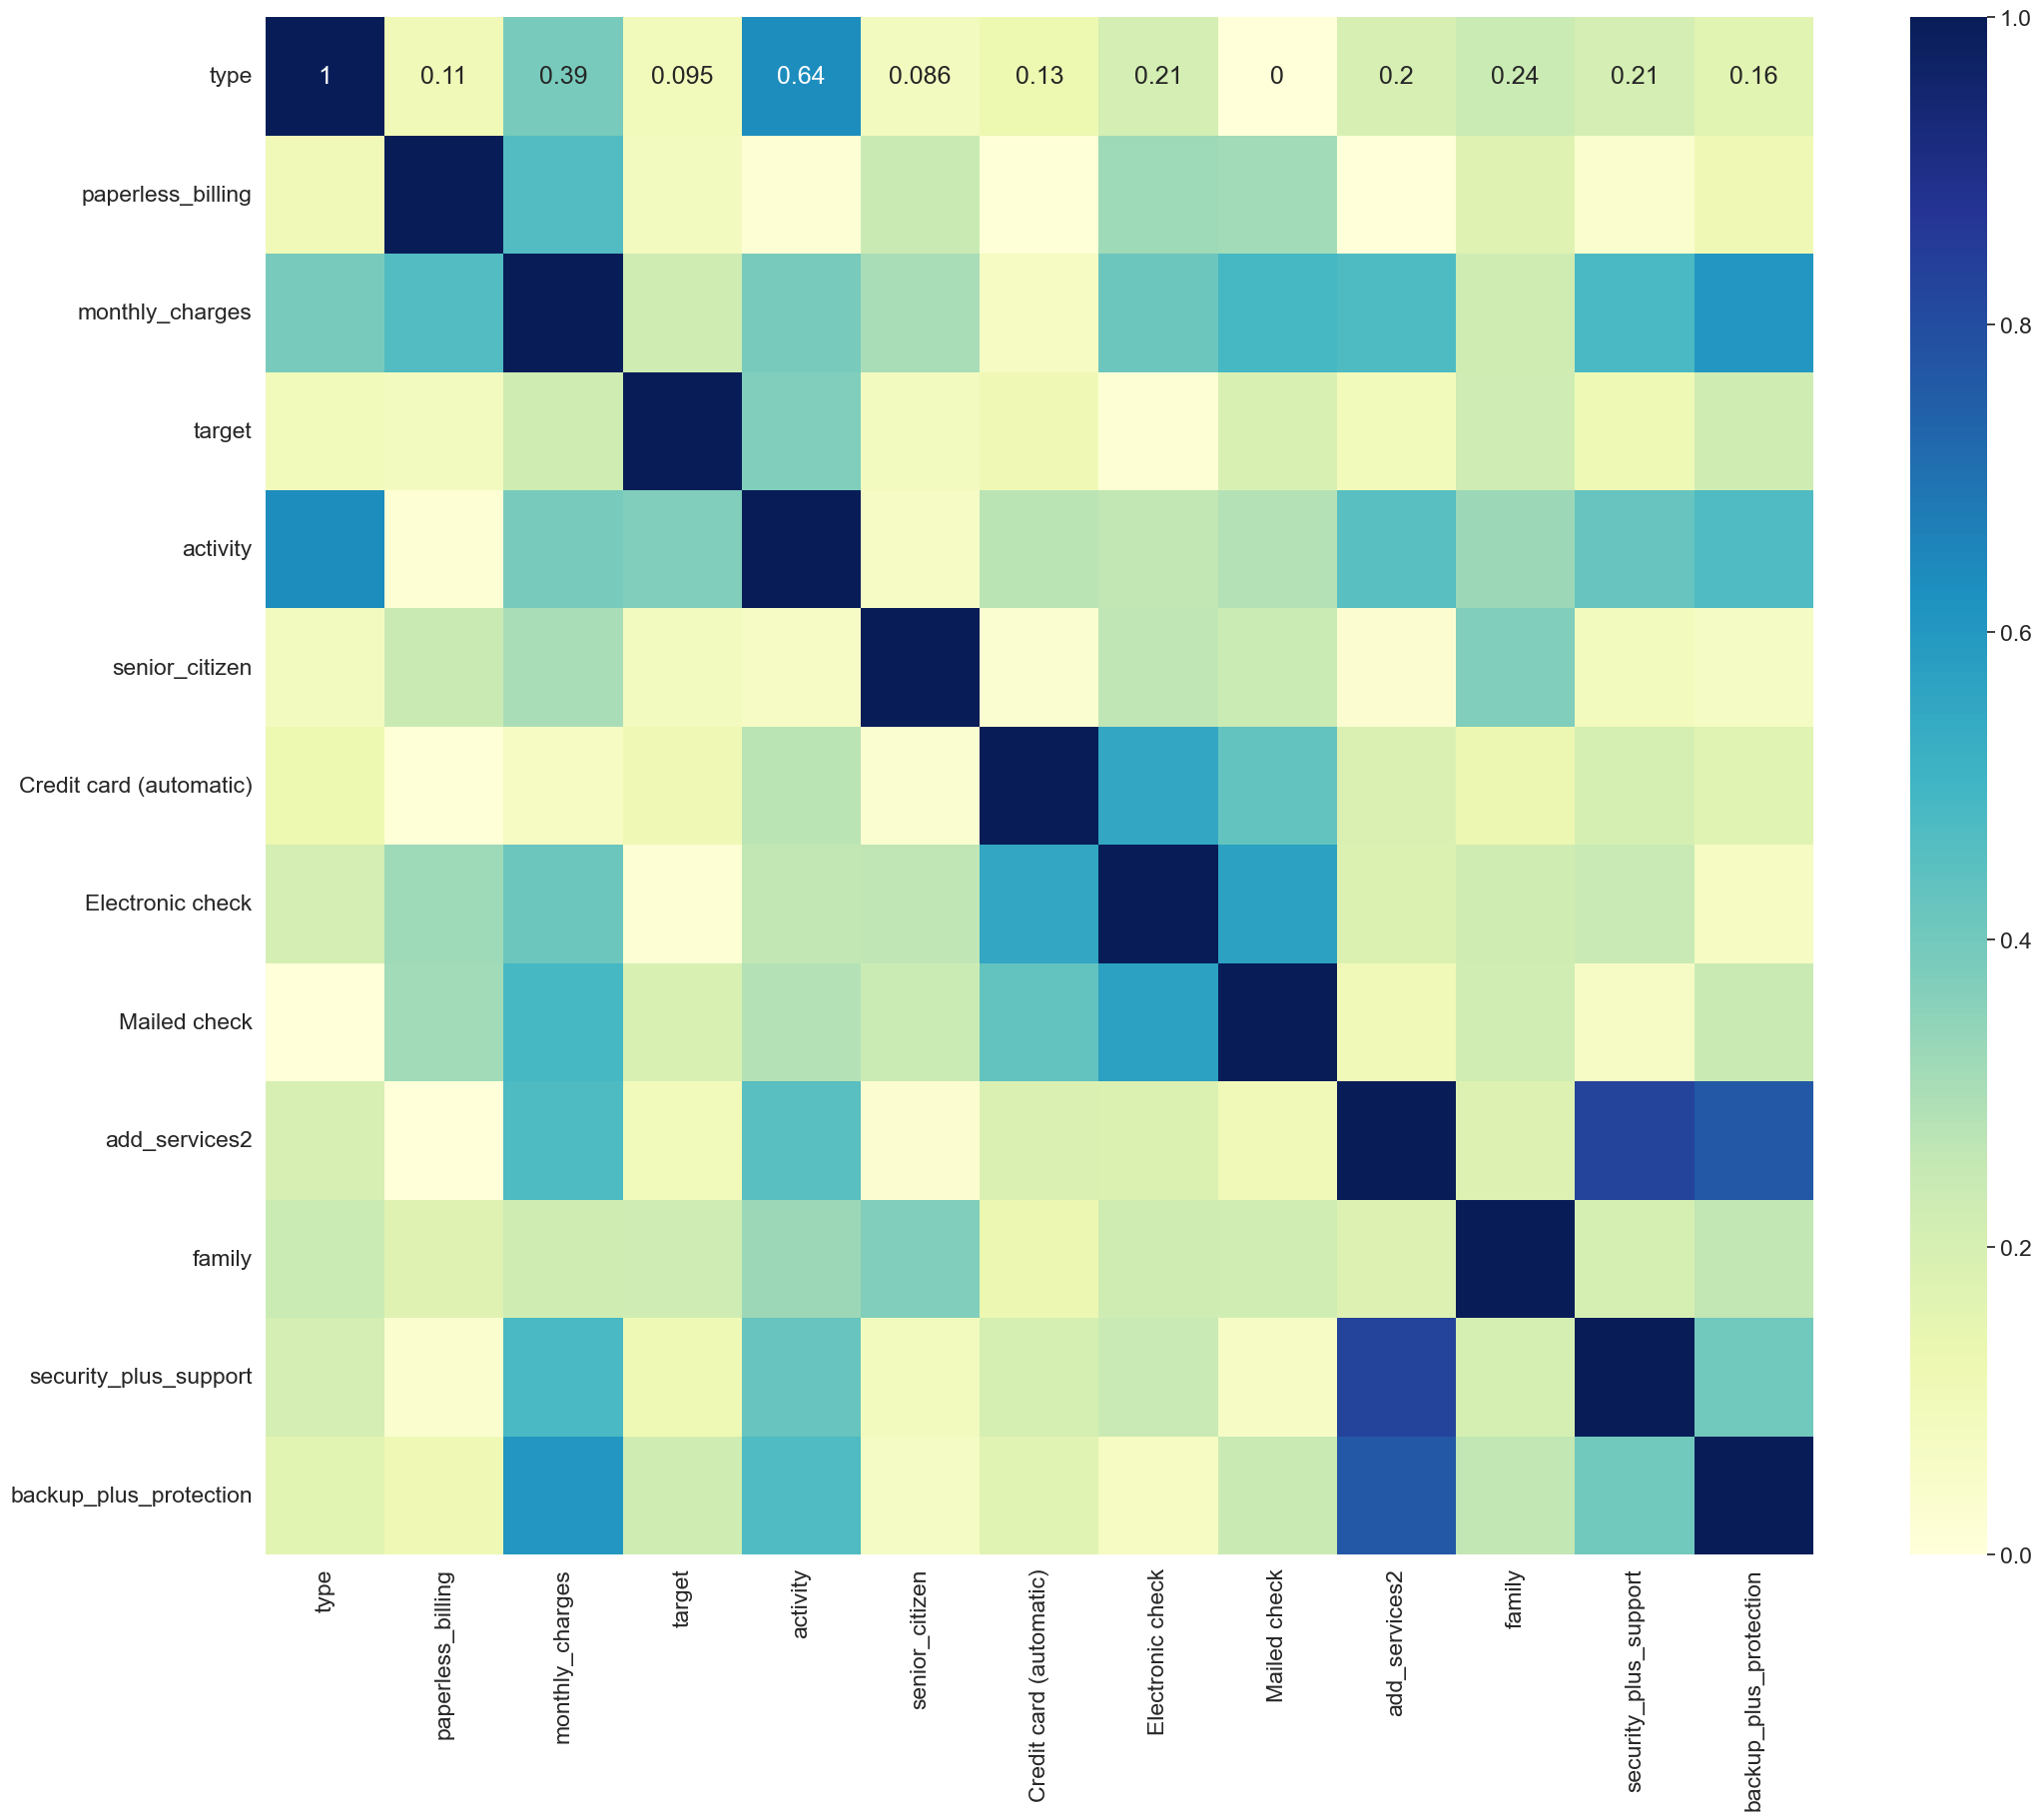

In [80]:
heatmap(work_df)

Удалим параметр 'add_services2', фичи из которого уже участвуют в датасете

In [82]:
work_df = work_df.drop(columns=['add_services2'])


# Обучение моделей

Будем обучать 3 модели:
1. Логистическую регрессию - простой математический алгоритм
2. Random Forest
3. Нейросеть

Сначала разделим подготовленный датасет на фичи и таргет

In [86]:
df, target = work_df.drop(columns='target'), work_df.target

In [87]:
df

,type,paperless_billing,monthly_charges,activity,senior_citizen,Credit card (automatic),Electronic check,Mailed check,family,security_plus_support,backup_plus_protection
0,1,1,29.85,31,0,0.0,1.0,0.0,-1.204448,0.0,0.0
1,12,0,56.95,1036,0,0.0,0.0,1.0,-2.120177,0.0,0.0
2,1,1,53.85,123,0,0.0,0.0,1.0,-2.120177,0.0,0.0
3,12,0,42.30,1371,0,0.0,0.0,0.0,-2.120177,1.0,0.0
4,1,1,70.70,153,0,0.0,1.0,0.0,-2.120177,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
7027,12,1,84.80,730,0,0.0,0.0,1.0,-1.427160,1.0,0.0
7028,12,1,103.20,2191,0,1.0,0.0,0.0,-1.427160,0.0,1.0
7029,1,1,29.60,337,0,0.0,1.0,0.0,-1.427160,0.0,0.0
7030,1,1,74.40,215,1,0.0,0.0,1.0,-1.204448,0.0,0.0


In [88]:
target

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
7027    0.0
7028    0.0
7029    0.0
7030    0.0
7031    0.0
Name: target, Length: 7032, dtype: float64

In [89]:
X_train, X_test, y_train, y_test = train_test_split(df, target, test_size=0.33, random_state=21, stratify = target)

## Логистическая регрессия

In [91]:
logreg = LogisticRegression()

logreg.fit(X_train, y_train)


LogisticRegression()

In [92]:
y_pred = logreg.predict(X_test)

print('Accuracy of logistic regression classifier on test set: {:.3f}'.format(logreg.score(X_test, y_test)))


Accuracy of logistic regression classifier on test set: 0.862


Точность первой и простейшей нашей модели составила - 0.86, что очень неплохо.

## Random Forest

Сначала построим модель с количеством деревьев по умолчанию, равному 10


In [96]:
rfc = RandomForestClassifier(random_state=0)

rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)

from sklearn.metrics import accuracy_score

print('Model accuracy score with 10 decision-trees : {0:0.3f}'. format(accuracy_score(y_test, y_pred)))


Model accuracy score with 10 decision-trees : 0.854


Теперь увеличим кол-во деревьев до 100


In [98]:
rfc_100 = RandomForestClassifier(n_estimators=100, random_state=0)

rfc_100.fit(X_train, y_train)

y_pred_100 = rfc_100.predict(X_test)

print('Model accuracy score with 100 decision-trees : {0:0.4f}'. format(accuracy_score(y_test, y_pred_100)))


Model accuracy score with 100 decision-trees : 0.8539


Видим что количество деревьев никак не повлияло на результат 

## Нейросеть

Будем использовать обычную, полносвязную нейросеть:
- количество слоёв: 5 слоёв;
- количество нейронов: начнем с 256 нейронов с последующим уменьшением;
- количество эпох установим в размере 50

Зафиксируем random state:


In [102]:
def random_stater(n):
    os.environ['PYTHONHASHSEED'] = '0'
    os.environ['CUDA_VISIBLE_DEVICES'] = ''
    random.seed(n)
    np.random.seed(n)
    tf.random.set_seed(n)
    

In [103]:
roc_metric = keras.metrics.AUC(
    num_thresholds=200,
    curve="ROC",
    summation_method="interpolation",
    name=None,
    dtype=None,
    thresholds=None,
    multi_label=False,
    num_labels=None,
    label_weights=None,
    from_logits=False,
)


In [104]:
random_stater(300123)
model = keras.models.Sequential()


model.add(keras.layers.Dense(units=256, input_dim = X_train.shape[1], activation='relu'))
model.add(keras.layers.Dense(units=128, activation='relu'))
model.add(keras.layers.Dense(units=16, activation='relu'))
model.add(keras.layers.Dense(units=8, activation='relu'))
model.add(keras.layers.Dense(units=1, activation='sigmoid'))


model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[roc_metric])


In [105]:
model.fit(X_train, y_train, validation_split=.2, epochs=50, verbose=2)


Epoch 1/50
118/118 - 2s - 20ms/step - auc: 0.5110 - loss: 0.9332 - val_auc: 0.4751 - val_loss: 0.7319
Epoch 2/50
118/118 - 0s - 2ms/step - auc: 0.4895 - loss: 0.9412 - val_auc: 0.7487 - val_loss: 0.4955
Epoch 3/50
118/118 - 0s - 2ms/step - auc: 0.6250 - loss: 0.4474 - val_auc: 0.6632 - val_loss: 0.4367
Epoch 4/50
118/118 - 0s - 2ms/step - auc: 0.5612 - loss: 0.6326 - val_auc: 0.6777 - val_loss: 0.4336
Epoch 5/50
118/118 - 0s - 2ms/step - auc: 0.6536 - loss: 0.4326 - val_auc: 0.7618 - val_loss: 0.3959
Epoch 6/50
118/118 - 0s - 2ms/step - auc: 0.6846 - loss: 0.4102 - val_auc: 0.7844 - val_loss: 0.3876
Epoch 7/50
118/118 - 0s - 2ms/step - auc: 0.7025 - loss: 0.4013 - val_auc: 0.8056 - val_loss: 0.3761
Epoch 8/50
118/118 - 0s - 2ms/step - auc: 0.7229 - loss: 0.3892 - val_auc: 0.7997 - val_loss: 0.3745
Epoch 9/50
118/118 - 0s - 3ms/step - auc: 0.7345 - loss: 0.3833 - val_auc: 0.7833 - val_loss: 0.3826
Epoch 10/50
118/118 - 0s - 2ms/step - auc: 0.7375 - loss: 0.3826 - val_auc: 0.8047 - val_l

In [106]:
print(roc_auc_score(y_train, model.predict(X_train)))


148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
0.8080396333789666


Точность модели нейросети показала результат - 0.81, что неплохо, но все же хуже чем у моделей логистической регрессии и случайного леса - 0.86 и 0.85 соответственно. Учитывая общепринятое значение достаточной для бизнеса точности в 0.80, считаю достигнутый результат хорошим и готовым к применению в реальной практике.

# Отчет о проделанной работе

## Описание задачи

Оператор связи хочет научиться прогнозировать отток клиентов. И если по итогам анализа выяснится что пользователь хочет уйти, ему будут предложены спец. условия или акции. 

Оператор предоставил персональные данные о некоторых клиентах, информацию о тарифах и договорах.

Были предоставлены четыре файла с данными.

## Цель проекта и план работ

Перед нами классическая задача классификации


План работ:
1. Провести EDA файлов, избавиться от дубликатов и ошибок, объединить таблицы в один файл.
2. Закодировать категориальные переменные (вручную, согласно некой "бизнес-логике")
3. Повторно провести EDA по объединенной таблице на предмет зависимостей переменных, проанализировать корреляцию, изучить коллинеарность фичей и некоррелирующие с таргетом фичи.
4. Синтезировать новые или преобразовать старые фичи, чтобы в будущем улучшить качество модели
5. Финально отобрать признаки для обучения
6. Собрать архитектуру для нейронки
7. Обучить модели; отобрать лучшую по результатам

- Используемые метрики: ROC-AUC
- Используемые модели: простая логистическая регрессия, случайный лес, нейронная сеть

В итоге мы выполнили все пункты нашего плана.

Но возникло несколько трудностей:
1.Не все фичи коррелировали с таргетом - объединили смежные, усилив влияние, некоторые пришлось удалисть вовсе..
2В EDA проекта пришлось заменять многие отсутствующие признаки на свое усмотрение, отсутствующие значения на нули, а например тип подключения интернета  - по его уровню современности.й


**EDA**

На данном этапе: 
- приводили данные к нужным нам типам; 
- убрали 11 записей с пропущенными данными;
- выделили таргет;
- посмотрели на зави-ть таргета от даты заключения и расторжения договора;
- объединили таблицы.

**Кодирование категориальных переменных**

На данном этапе:
- закодировали все "Yes" и "No" как нули и единицы;
- заменили пропущенные значения на новые, в зависимости от признака.
- закодировали признак 'тип договора' по его продолжительности;
- закодировали признак 'услуги интернет' по возрастанию "продвинутости" технологии;
- закодировали 'пол и способ оплаты' с помощью one-hot кодировки, чтобы не упустить корреляции

**Сбор архитектуры для нейронки**

При сборе архитектуре для нейронки руководствовались основными принципами библиотеки [__DatRet__](https://habr.com/ru/post/712088/) для табличных данных:
- 10 слоев;
- количество нейронов начинается с 512, уменьшается в 2 раза на каждом слое;
- кастомный оптимизатор __adam__

В итоге было решено отказаться от кастомного оптимизатора и такого количества слоёв: множественные эксперименты привели нас к текущей архитектуре нейронной сети.

Однако же мы собрали кастомную метрику - __roc-auc__ - чтобы отслеживать качество модели в процессе обучения

**Обучение и результаты моделей**

Точность модели нейросети показала результат - 0.81, что неплохо, но все же хуже чем у моделей логистической регрессии и случайного леса - 0.86 и 0.85 соответственно. Учитывая общепринятое значение достаточной для бизнеса точности в 0.80, считаю достигнутый результат хорошим и готовым к применению в реальной практике.